<a href="https://colab.research.google.com/github/sam939z/COMP9517-Vistopia/blob/main/ResNet18.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

tqdm + ablation study + "Accuracy", "Precision", "Recall", "F1-score"

In [1]:
#link Google Drive
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
#import + tqdm
import os, shutil, zipfile, time
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from torchvision import transforms
from torchvision.datasets import ImageFolder
from torchvision.models import resnet18
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_score, recall_score, f1_score
from tqdm import tqdm
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import torch
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import classification_report

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [3]:
#unzip
zip_path = "/content/drive/MyDrive/9517/Aerial_Landscapes.zip"
unzip_root = "/content/dataset"
extract_path = unzip_root + "/Aerial_Landscapes"

with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(unzip_root)

In [4]:
#train/val
split_base = "/content/split_dataset"
os.makedirs(split_base + "/train", exist_ok=True)
os.makedirs(split_base + "/val", exist_ok=True)

for class_name in os.listdir(extract_path):
    class_dir = os.path.join(extract_path, class_name)
    if not os.path.isdir(class_dir):
        continue
    imgs = os.listdir(class_dir)
    train_imgs, val_imgs = train_test_split(imgs, test_size=0.2, random_state=42)

    for phase, image_list in zip(['train', 'val'], [train_imgs, val_imgs]):
        dst_class_dir = os.path.join(split_base, phase, class_name)
        os.makedirs(dst_class_dir, exist_ok=True)
        for img in image_list:
            src = os.path.join(class_dir, img)
            dst = os.path.join(dst_class_dir, img)
            if os.path.isfile(src):
                shutil.copy(src, dst)

In [5]:
#set ablation study
ablation_configs = {
    "A (baseline)": {"augment": False, "dropout": False},
    "B (+augment)": {"augment": True, "dropout": False},
    "C (+dropout)": {"augment": False, "dropout": True},
    "D (+augment+dropout)": {"augment": True, "dropout": True},
}

In [6]:
#data transform
def get_transform(augment):
    if augment:
        return transforms.Compose([
            transforms.RandomResizedCrop(128, scale=(0.9, 1.0)),  # 微调视角/缩放
            transforms.ColorJitter(0.2, 0.2, 0.1, 0.05),   # 模拟亮度、对比度、饱和度、色调变化
            transforms.ToTensor()
        ])
    else:
        return transforms.Compose([
            transforms.Resize((128, 128)),
            transforms.ToTensor(),
        ])



In [7]:
#model
def get_model(num_classes, use_dropout):
    model = resnet18(pretrained=True)
    if use_dropout:
        model.fc = nn.Sequential(
            nn.Dropout(0.5),
            nn.Linear(model.fc.in_features, num_classes)
        )
    else:
        model.fc = nn.Linear(model.fc.in_features, num_classes)
    return model

In [8]:
#train（tqdm + val）
def train_model(model, train_loader, val_loader, device, epochs=2, class_names=None):
    model.to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)

    for epoch in range(epochs):
        model.train()
        loop = tqdm(train_loader, desc=f"Epoch {epoch+1}/{epochs}")
        for imgs, labels in loop:
            imgs, labels = imgs.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(imgs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            loop.set_postfix(loss=loss.item())

    #validation set evaluation
    model.eval()
    y_true, y_pred = [] , []
    correct_imgs, wrong_imgs = [], []
    with torch.no_grad():
        for imgs, labels in val_loader:
            imgs = imgs.to(device)
            outputs = model(imgs)
            preds = outputs.argmax(1).cpu()
            y_true.extend(labels.tolist())
            y_pred.extend(preds.tolist())

            for i in range(len(imgs)):
                if preds[i] == labels[i]:
                    correct_imgs.append((imgs[i].cpu(), labels[i], preds[i]))
                else:
                    wrong_imgs.append((imgs[i].cpu(), labels[i], preds[i]))

    precision = precision_score(y_true, y_pred, average='macro')
    recall = recall_score(y_true, y_pred, average='macro')
    f1 = f1_score(y_true, y_pred, average='macro')

    # confusion_matrix
    if class_names:
        cm = confusion_matrix(y_true, y_pred, labels=list(range(len(class_names))))
        disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
        disp.plot(xticks_rotation=90, cmap='Blues')
        plt.title("Confusion Matrix")
        plt.grid(False)
        plt.show()

    # classification_report
    if class_names:
      report = classification_report(y_true, y_pred, target_names=class_names, digits=2)
      print("Classification Report:\n")
      print(report)

    return precision*100, recall*100, f1*100, correct_imgs, wrong_imgs



💻 Running Group A (baseline): {'augment': False, 'dropout': False}


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Epoch 2/2: 100%|██████████| 600/600 [00:28<00:00, 21.00it/s, loss=0.0169]


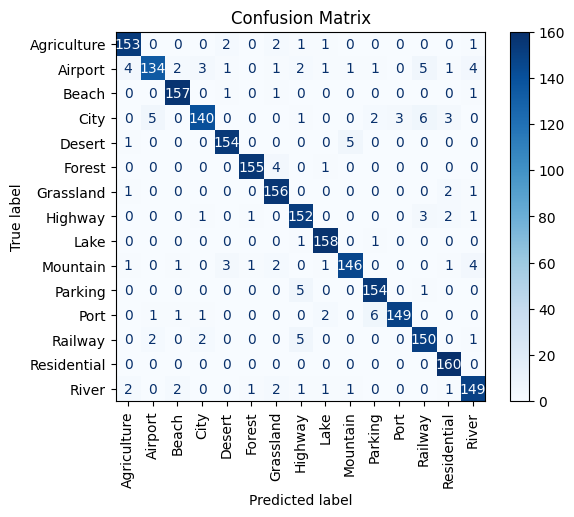

Classification Report:

              precision    recall  f1-score   support

 Agriculture       0.94      0.96      0.95       160
     Airport       0.94      0.84      0.89       160
       Beach       0.96      0.98      0.97       160
        City       0.95      0.88      0.91       160
      Desert       0.96      0.96      0.96       160
      Forest       0.98      0.97      0.97       160
   Grassland       0.93      0.97      0.95       160
     Highway       0.90      0.95      0.93       160
        Lake       0.96      0.99      0.97       160
    Mountain       0.95      0.91      0.93       160
     Parking       0.94      0.96      0.95       160
        Port       0.98      0.93      0.96       160
     Railway       0.91      0.94      0.92       160
 Residential       0.94      1.00      0.97       160
       River       0.92      0.93      0.93       160

    accuracy                           0.94      2400
   macro avg       0.95      0.94      0.94      2400
we

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Epoch 2/2: 100%|██████████| 600/600 [00:58<00:00, 10.17it/s, loss=0.297]


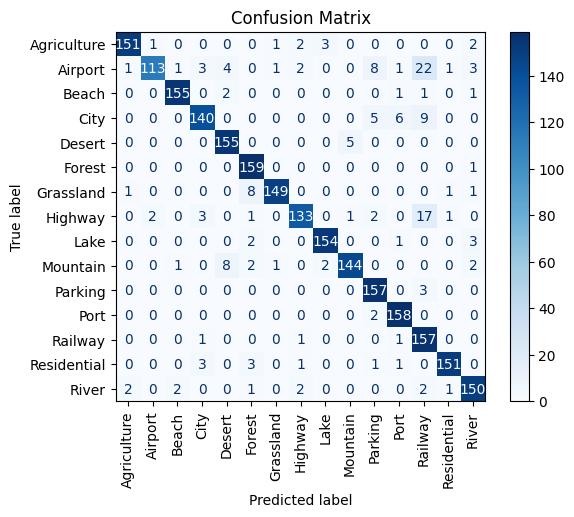

Classification Report:

              precision    recall  f1-score   support

 Agriculture       0.97      0.94      0.96       160
     Airport       0.97      0.71      0.82       160
       Beach       0.97      0.97      0.97       160
        City       0.93      0.88      0.90       160
      Desert       0.92      0.97      0.94       160
      Forest       0.90      0.99      0.95       160
   Grassland       0.98      0.93      0.96       160
     Highway       0.94      0.83      0.88       160
        Lake       0.97      0.96      0.97       160
    Mountain       0.96      0.90      0.93       160
     Parking       0.90      0.98      0.94       160
        Port       0.93      0.99      0.96       160
     Railway       0.74      0.98      0.85       160
 Residential       0.97      0.94      0.96       160
       River       0.92      0.94      0.93       160

    accuracy                           0.93      2400
   macro avg       0.93      0.93      0.93      2400
we

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Epoch 2/2: 100%|██████████| 600/600 [00:29<00:00, 20.46it/s, loss=0.46]


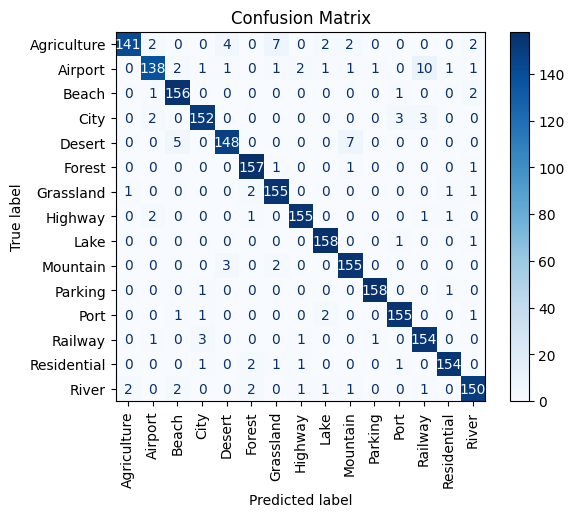

Classification Report:

              precision    recall  f1-score   support

 Agriculture       0.98      0.88      0.93       160
     Airport       0.95      0.86      0.90       160
       Beach       0.94      0.97      0.96       160
        City       0.96      0.95      0.95       160
      Desert       0.95      0.93      0.94       160
      Forest       0.96      0.98      0.97       160
   Grassland       0.93      0.97      0.95       160
     Highway       0.97      0.97      0.97       160
        Lake       0.96      0.99      0.98       160
    Mountain       0.93      0.97      0.95       160
     Parking       0.99      0.99      0.99       160
        Port       0.96      0.97      0.97       160
     Railway       0.91      0.96      0.94       160
 Residential       0.97      0.96      0.97       160
       River       0.94      0.94      0.94       160

    accuracy                           0.95      2400
   macro avg       0.95      0.95      0.95      2400
we

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Epoch 2/2: 100%|██████████| 600/600 [01:00<00:00,  9.85it/s, loss=0.196]


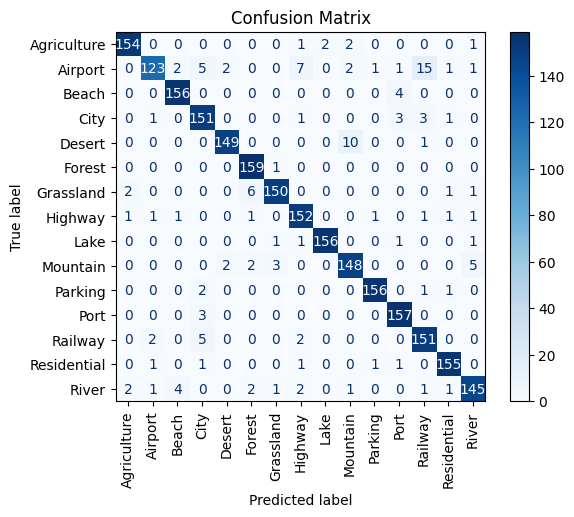

Classification Report:

              precision    recall  f1-score   support

 Agriculture       0.97      0.96      0.97       160
     Airport       0.95      0.77      0.85       160
       Beach       0.96      0.97      0.97       160
        City       0.90      0.94      0.92       160
      Desert       0.97      0.93      0.95       160
      Forest       0.94      0.99      0.96       160
   Grassland       0.96      0.94      0.95       160
     Highway       0.91      0.95      0.93       160
        Lake       0.99      0.97      0.98       160
    Mountain       0.91      0.93      0.92       160
     Parking       0.98      0.97      0.98       160
        Port       0.94      0.98      0.96       160
     Railway       0.87      0.94      0.91       160
 Residential       0.96      0.97      0.97       160
       River       0.94      0.91      0.92       160

    accuracy                           0.94      2400
   macro avg       0.94      0.94      0.94      2400
we

In [9]:
# run all groups
results = []

for name, cfg in ablation_configs.items():
    print(f"\n💻 Running Group {name}: {cfg}")
    transform = get_transform(cfg["augment"])
    train_ds = ImageFolder(split_base + "/train", transform=transform)
    val_ds = ImageFolder(split_base + "/val", transform=transform)
    train_loader = DataLoader(train_ds, batch_size=16, shuffle=True)
    val_loader = DataLoader(val_ds, batch_size=16)

    model = get_model(len(train_ds.classes), cfg["dropout"])
    start = time.time()

    prec, rec, f1, correct_imgs, wrong_imgs = train_model(
    model, train_loader, val_loader, device, class_names=train_ds.classes
)
    acc = 100 * len(correct_imgs) / (len(correct_imgs) + len(wrong_imgs))


    end = time.time()
    print(f" Finished {name} in {end-start:.1f}s\n")
    results.append([name, acc, prec*100, rec*100, f1*100])

Correct Predictions


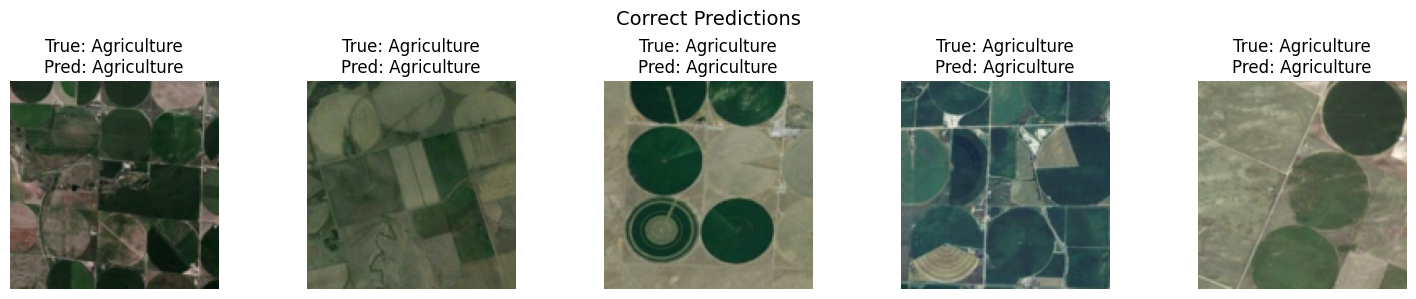

Incorrect Predictions


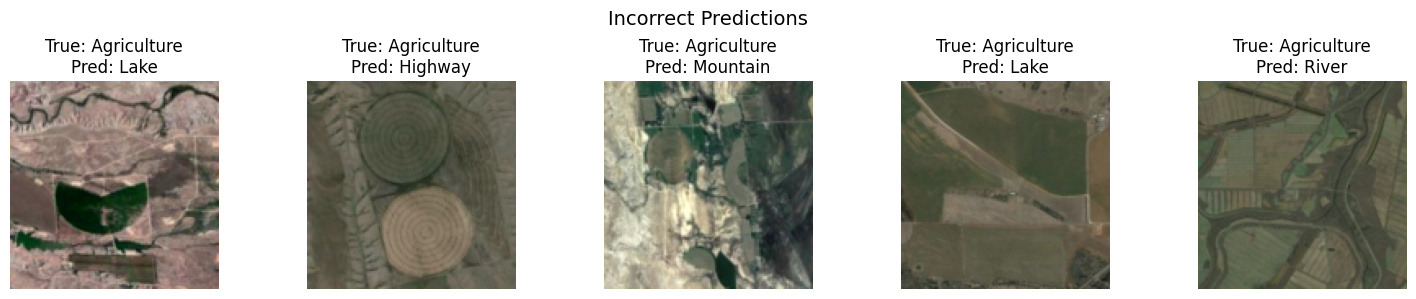

In [10]:
# Correct Predictions
print("Correct Predictions")
n_show = min(5, len(correct_imgs))
plt.figure(figsize=(15, 3))
for i in range(n_show):
    img, label, pred = correct_imgs[i]
    plt.subplot(1, n_show, i + 1)
    plt.imshow(np.transpose(img.numpy(), (1, 2, 0)))
    plt.title(f"True: {train_ds.classes[label]}\nPred: {train_ds.classes[pred]}")
    plt.axis('off')
plt.suptitle("Correct Predictions", fontsize=14)
plt.tight_layout()
plt.show()

#Incorrect Predictions
print("Incorrect Predictions")
n_show = min(5, len(wrong_imgs))
plt.figure(figsize=(15, 3))
for i in range(n_show):
    img, label, pred = wrong_imgs[i]
    plt.subplot(1, n_show, i + 1)
    plt.imshow(np.transpose(img.numpy(), (1, 2, 0)))
    plt.title(f"True: {train_ds.classes[label]}\nPred: {train_ds.classes[pred]}")
    plt.axis('off')
plt.suptitle("Incorrect Predictions", fontsize=14)
plt.tight_layout()
plt.show()



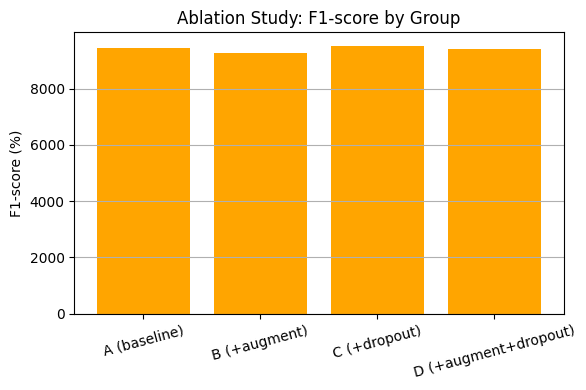

,Group,Accuracy,Precision,Recall,F1-score
0,A (baseline),94.458333,9450.451614,9445.833333,9442.339656
1,B (+augment),92.750000,9333.149559,9275.000000,9270.895663
2,C (+dropout),95.250000,9529.432266,9525.000000,9522.632023
3,D (+augment+dropout),94.250000,9434.516880,9425.000000,9420.052973


In [11]:
# visualization
results_df = pd.DataFrame(results, columns=["Group", "Accuracy", "Precision", "Recall", "F1-score"])

# show bar chart F1-score
plt.figure(figsize=(6, 4))
plt.bar(results_df["Group"], results_df["F1-score"], color='orange')
plt.title("Ablation Study: F1-score by Group")
plt.ylabel("F1-score (%)")
plt.xticks(rotation=15)
plt.grid(axis='y')
plt.tight_layout()
plt.show()
display(results_df)
